In [2]:
from utilities.preprocessing import *
import seaborn as sns
import os
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import plotly
import plotly.graph_objects as go
import networkx as nx
import igraph as ig
import numba
import itertools
from console_progressbar import ProgressBar
import re
from graph_tool.all import *
import graph_tool as gt
from math import *
import matplotlib


In [2]:
path = '../trending_yt_videos/'

'Import json'
with open(path + 'US_category_id.json') as f:
  videos = json.load(f)

'Save all the categories in dict[id]=category'
categories = {}
for cat in videos['items']:
    # print(cat)
    this_cat = cat['snippet']['title']
    id = cat['id']
    categories[id] = this_cat


In [3]:
len(categories.keys())

32

In [4]:
'Import video dataset:'

video_stats = pd.read_csv(path + 'USvideos.csv')
video_stats = video_stats.replace({'likes':0,'dislikes':0,'comment_count':0},np.nan)
video_stats.dropna(subset=['likes','dislikes','comment_count'],inplace=True)

# EDA

In [6]:
video_stats.head(3)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527.0,2966.0,15954.0,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185.0,6146.0,12703.0,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033.0,5339.0,8181.0,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...


/tmp/ipykernel_17104/1396074019.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


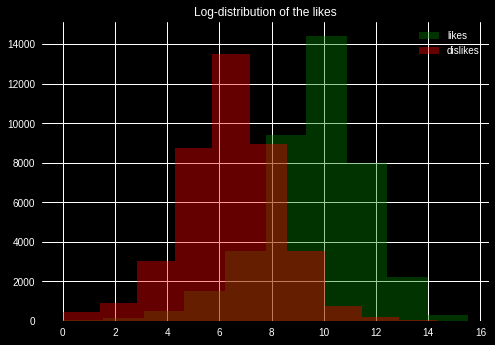

In [277]:
plt.style.use('dark_background')
likes = video_stats.likes#[np.asarray(video_stats.likes != 0)]
dislikes = video_stats.dislikes#[np.asarray(video_stats.dislikes != 0)]
plt.hist(np.log(likes),color = 'green',alpha=0.4,label='likes')
plt.hist(np.log(dislikes),color = 'red',alpha=0.4,label='dislikes')
plt.title('Log-distribution of the likes')
plt.legend()
fig.show()

Text(0.5, 1.0, 'Log distribution of dislikes to likes ratio')

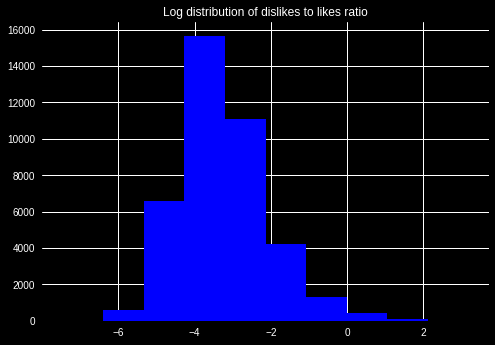

In [278]:
plt.hist(np.log(dislikes/likes),color='blue')
plt.title('Log distribution of dislikes to likes ratio')

Text(0.5, 0.98, 'Log10 distribution of likes & dislikes to views ratios')

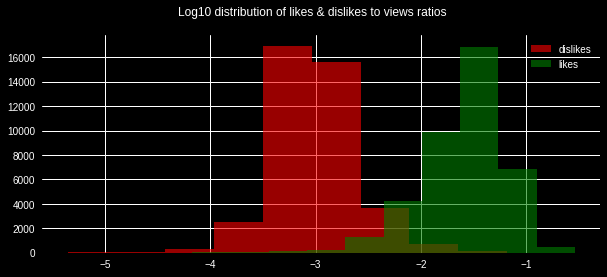

In [279]:
views = video_stats.views[video_stats.views != 0]
fig, ax = plt.subplots(1,1, figsize = (10,4))
ax.hist(np.log10(dislikes/views),color = 'red',label = 'dislikes',alpha=0.6)
# ax.set_xscale('log')
ax.hist(np.log10(likes/views),color = 'green', label = 'likes',alpha=0.6)
# ax.set_xticks(x_ticks)
# ax.set_xticklabels([f'10^({x})' for x in x_ticks])
plt.legend()
plt.suptitle('Log10 distribution of likes & dislikes to views ratios')

Text(0.5, 1.0, 'Log10 distribution of (likes/dislikes)/views')

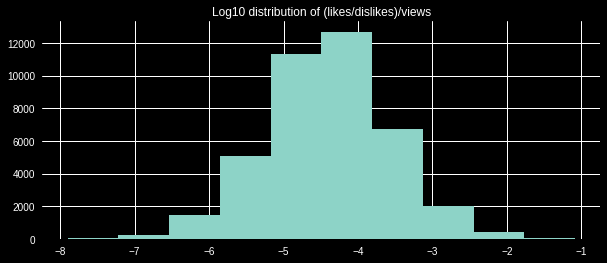

In [280]:
fig, ax = plt.subplots(1,1, figsize = (10,4))
ax.hist(np.log10((likes/dislikes)/(views)))
# ax.set_xscale('log')
# x_ticks = [-4,-3,-2,-1,0]
# ax.set_xticks(x_ticks)
# ax.set_xticklabels([f'10^({x})' for x in x_ticks])
plt.title('Log10 distribution of (likes/dislikes)/views')

In [281]:
set(video_stats.category_id)

{1, 2, 10, 15, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 43}

In [282]:
new_col = [categories[f'{id}'] for id in video_stats.category_id]
video_stats['category'] = new_col

In [283]:
video_stats.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527.0,2966.0,15954.0,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185.0,6146.0,12703.0,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",Entertainment
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033.0,5339.0,8181.0,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,Comedy
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172.0,666.0,2146.0,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,Entertainment
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235.0,1989.0,17518.0,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,Entertainment


In [292]:
video_stats.tags[3]

'rhett and link|"gmm"|"good mythical morning"|"rhett and link good mythical morning"|"good mythical morning rhett and link"|"mythical morning"|"Season 12"|"nickelback lyrics"|"nickelback lyrics real or fake"|"nickelback"|"nickelback songs"|"nickelback song"|"rhett link nickelback"|"gmm nickelback"|"lyrics (website category)"|"nickelback (musical group)"|"rock"|"music"|"lyrics"|"chad kroeger"|"canada"|"music (industry)"|"mythical"|"gmm challenge"|"comedy"|"funny"|"challenge"'

In [285]:

video_stats['VLratio'] = video_stats.views/video_stats.likes
video_stats['VDratio'] = video_stats.views/video_stats.dislikes
video_stats['LDratio'] = video_stats.likes/video_stats.dislikes
video_stats['VCratio'] = video_stats.views/video_stats.comment_count

video_stats['log10VLratio'] = video_stats.VLratio.apply(np.log10)
video_stats['log10VDratio'] = video_stats.VDratio.apply(np.log10)
video_stats['log10LDratio'] = video_stats.LDratio.apply(np.log10)
video_stats['log10VCratio'] = video_stats.VCratio.apply(np.log10)

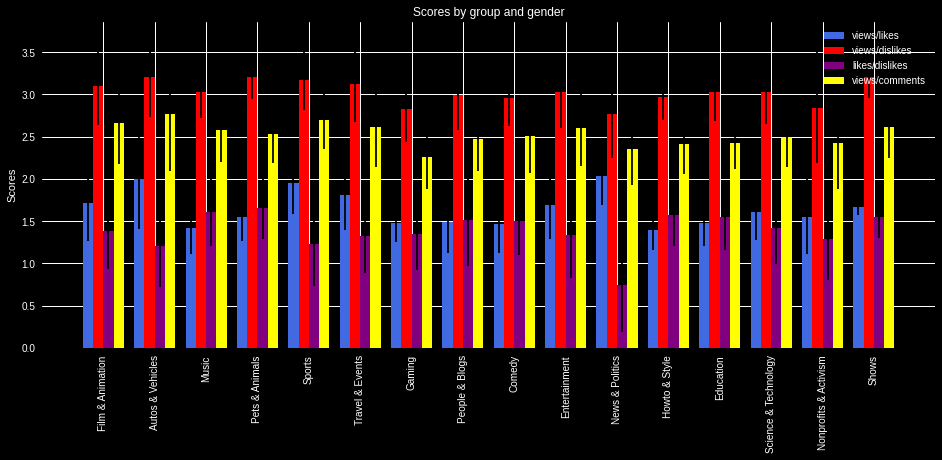

In [291]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-deep')

catmeans = video_stats.groupby('category_id').mean()
catstds = video_stats.groupby('category_id').std()

# likeMeans = catmeans.LVratio
# likeStd =   catstds.LVratio

likeMeans = catmeans.log10VLratio
likeStd =   catstds.log10VLratio

N = len(likeMeans)
ind = np.arange(N)  # the x locations for the groups
width = 0.20      # the width of the bars

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, likeMeans, width, color='royalblue', yerr=likeStd)

dislikeMeans = catmeans.log10VDratio
dislikeStd =   catstds.log10VDratio
# dislikeMeans = np.log10(catmeans.DVratio)
# dislikeStd =   np.log10(catstds.DVratio)

rects2 = ax.bar(ind+width, dislikeMeans, width, color='red', yerr= dislikeStd)

LDMeans = catmeans.log10LDratio
LDStd =   catstds.log10LDratio
# DLMeans = np.log10(catmeans.DLratio)
# DLStd =   np.log10(catstds.DLratio)

rects3 = ax.bar(ind+width*2, LDMeans, width, color='purple', yerr= LDStd)

VCMeans = catmeans.log10VCratio
VCStd = catstds.log10VCratio

rects4 = ax.bar(ind+width*3, VCMeans, width, color='yellow', yerr= VCStd)

# add some
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(ind + width*1.5 )
ax.set_xticklabels( [categories[f'{id}'] for id in list(catmeans.index)]) 

ax.legend( (rects1[0], rects2[0], rects3[0], rects4[0]), 
            ('views/likes', 'views/dislikes','likes/dislikes','views/comments'),
            loc = 'upper right')
plt.xticks(rotation=90)
plt.show()

# Creating the graph from the video dataset

In [7]:

# @numba.njit
def build_edgesnodes(videos,save=False,path=None):
    '''
    ----------------------------------------------------------------------------------------
    Takes a dataframe and returns the list of nodes and edges, and the dictionary mapping 
    for each tag the corresponding category
    Parameters:
        - videos: dataframe
        - save: if True saves to "path"
        - path: string
    ----------------------------------------------------------------------------------------
    '''
    
    pb = ProgressBar(total=100,prefix='Done:', suffix='Now', decimals=0, length=50, fill='#', zfill='-')

    list_of_tags = [videos.channel_title.values[idx] + '|' + videos.tags.values[idx] for idx in range(len(videos))]
    list_of_tags = [re.sub("\"","",tag).split('|') for tag in list_of_tags]

    len_graph = []
    for vg in list_of_tags:
        len_graph.extend(vg)    

    if save and not path:
        raise ValueError('Please insert a valid path in which to save the nodes and edges!')
    elif save and path:
        if not os.path.exists(path):
            os.makedirs(path)
    
    nodes = {node:k for k,node in enumerate(list(set(len_graph)))}
    
    # print(list_of_tags)
    tagcategories = {}
    for row,tags in enumerate(list_of_tags):
        for tag in tags:
            cat_id = str(videos.iloc[row].category_id)
            if tag not in tagcategories:
                # tag_categories[tag] = [str(int(videos.iloc[row].category_id))]
                tagcategories[tag] = [categories[cat_id]]
            elif tag in tagcategories and categories[cat_id] not in tagcategories[tag]:
                # tag_categories[tag].append(str(int(videos.iloc[row].category_id)))
                tagcategories[tag].append(categories[cat_id])
        

    len_graph = len(set(len_graph))


    edges = []


    for counter,tags in enumerate(list_of_tags):
        progress = int((counter+1)/len(list_of_tags) * 100)
        pb.print_progress_bar(progress)     
        edges.extend(list(itertools.combinations(tags,2)))
        edges = list(set(edges))
    
    if save:
        '''
        Save nodes:
        '''
        nodes_df = pd.DataFrame(nodes.keys())
        nodes_df['Id'] = nodes.values()
        nodes_df.columns = ['Label','Id']
        nodes_df['Category'] = [tag_categories[tag] for tag in nodes_df.Label.values]
        nodes_df.drop(nodes_df.index[0],inplace=True)
        nodes_df = nodes_df.reindex(columns = ['Id','Label','Category'])
        nodes_df.drop(nodes_df[nodes_df.Id == 0].index, inplace = True)
        pd.DataFrame(nodes_df).to_csv('nodes.csv',index=False)

        '''
        Save edges:
        '''
        edges_df = pd.DataFrame([source[0] for source in edges])
        edges_df.columns = ['From']
        edges_df['To'] = [source[1] for source in edges]
        edges_df['Source'] = [nodes[source[0]] for source in edges]
        edges_df['Target'] = [nodes[source[1]] for source in edges]
        edges_df = edges_df.reindex(columns = ['Source','Target','From','To'])

        edges_df.drop(edges_df[edges_df.Target == 0].index, inplace = True)
        edges_df.drop(edges_df[edges_df.Source == 0].index, inplace = True)

        'Save nodes to nodes.csv'
        edges_df.to_csv('edges.csv',index=False)
        

    return nodes,edges,tagcategories

In [38]:
%%time
'''
Build nodes and edges
'''

nodes,edges,tag_categories = build_edgesnodes(video_stats,save=False,path=None) #build_edgesnodes(video_stats.iloc[:1000])

Done: |##################################################| 100% Now
CPU times: user 3h 41min 35s, sys: 16min 14s, total: 3h 57min 49s
Wall time: 3h 56min 56s


In [3]:
'''
Load edges and tones:
'''
nodes = pd.read_csv('../data/nodes.csv')
edges = pd.read_csv('../data/edges.csv')

In [12]:
edges.head()

,Source,Target,From,To
0,37930,16574,interesting finds,swimming
1,49908,19127,snl,SZA
2,23644,45851,JimBrowski 96HourNews,KELLYANNE CONWAY THIS WEEK ABC 11/12/17
3,26432,9336,black hole,universe
4,35938,47924,jewelry bling,gq jewelry tour


In [13]:
# g_test = nx.froms_dict_of_lists(dict_edges)
# g_test = nx.from_edgelist([(edges.From.values[i],edges.To.values[i]) for i in range(len(edges))])
# plt.plot(np.log(nx.degree_histogram(g_test)))
# plt.show()
# print(f'Assortativity coefficient: {nx.degree_assortativity_coefficient(g_test)}')


In [4]:
categories = {nodes.Label.values[i]:nodes.Category.values[i] for i in range(len(nodes))}

In [5]:
'''
Build graph:
'''
g = gt.Graph()
v_cat = g.new_vertex_property("string")
v_lab = g.new_vertex_property("string")


for j in range(0, len(nodes)):
    v = g.add_vertex()
    v_lab[v] = nodes.Label.values[j]
    v_cat[v] = categories[nodes.Label.values[j]]

for i in range(0,len(edges)):
    v1 = edges.Source.values[i]
    v2 = edges.Target.values[i]

    # if v1 not in list(v_lab):
    #     v = g.add_vertex()
    #     v_lab[v] = nodes.Label.values[v1]
    #     v_cat[v] = categories[nodes.Label.values[v1]]
    
    # if v2 not in list(v_lab):
    #     v = g.add_vertex()
    #     v_lab[v] = nodes.Label.values[v2]
    #     v_cat[v] = categories[nodes.Label.values[v2]]
    
    e = g.add_edge(v1,v2)
    

## Network statistics: in-degree distribution, powerlaw and gamma estimation

In [ ]:
'''
In-Degree distribution
'''
kmin = 30

plt.style.use('seaborn-deep')

in_hist = gt.stats.vertex_hist(g, "in")

y = in_hist[0]
err = np.sqrt(in_hist[0])
err[err >= y] = y[err >= y] - 1e-2

plt.figure(figsize=(6,4))
# plt.errorbar(in_hist[1][:-1], in_hist[0], fmt=".", yerr=err,
#         label="in",alpha=0.2,color = 'darkred')
plt.scatter(in_hist[1][:-1], in_hist[0], alpha=0.4,color='darkred',s=[10 if i < len(in_hist[0])//20 else 3 for i in range(len(in_hist[0]))])
plt.gca().set_yscale("log")
plt.gca().set_xscale("log")
plt.gca().set_ylim(1e-1, 1e5)
plt.gca().set_xlim(0.8, 1e3)
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.xlabel("$k_{in}$")
plt.ylabel("$NP(k_{in})$")
plt.tight_layout()
plt.vlines(x=kmin,ymin = 1e-1, ymax = 1e5,color = 'green',linestyles='dashdot')
plt.text(kmin,0.1-0.05,'$k_{min}$',rotation=0)
# savefig("price-deg-dist.pdf")
# savefig("price-deg-dist.svg")
plt.title('In degree distribution',alpha=0.5)
plt.savefig('../images/indegree_dist.pdf')

In [ ]:
'''
Finding gamma:
'''
def compute_gamma(graph,kmin):
    '''
    Parameters:
        - graph: graph to be considered;
        - kmin: min degree to consider to compute gamma, if None kmin will be min(degrees)
    '''
    vhist = graph.get_in_degrees(vs=list(graph.vertices()))

    if not kmin:
        kmin = min(vhis)

    true_k = vhist[vhist>=kmin]
    N = len(true_k)

    den = np.sum(np.log(vhist[vhist>=kmin]/kmin))

    gamma = 1 + N/den
    C = (gamma - 1)*kmin**(gamma - 1)
    
    return gamma,kmin,C


gamma,kmin,C = compute_gamma(g,kmin)
print(f'Gamma: {gamma},kmin: {kmin}, C: {C}')

'''
Confront with real distribution
'''
x = np.linspace(kmin,max(gt.stats.vertex_hist(g,"in")[1]))
y = C * (x/kmin) **(-gamma)

plt.figure(figsize=(6,4))
plt.plot(x,y,color='green',linestyle='dashed',label='power-law')
plt.scatter(in_hist[1][:-1], in_hist[0], alpha=0.4,color='darkred',s=[10 if i < len(in_hist[0])//20 else 3 for i in range(len(in_hist[0]))],label='in-degrees')

plt.gca().set_yscale("log")
plt.gca().set_xscale("log")
plt.gca().set_ylim(1e-0, 1e4)
plt.gca().set_xlim(0.8, 1e4)
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.xlabel("$k_{in}$")
plt.ylabel("$NP(k_{in})$")
plt.tight_layout()
plt.title('In-degree distribution',alpha=0.6)
plt.legend()
plt.savefig('../images/indegree_dist_vs_powerlaw.pdf')


In [ ]:
'''
Largest hub distribution:
'''
#If the network is scale free we have to find that k_max ~ N ^ 1/(gamma - 1)
def compute_n(graph,kmin):
    
    gamma,kmin,C = compute_gamma(graph,kmin)

    vhist = graph.get_in_degrees(vs=list(graph.vertices()))

    vhist = vhist[vhist>=kmin]

    N = []
    kmaxs = []
    for kmax in sorted(vhist):
        N.append(1/len(vhist[vhist>=kmax]))
        kmaxs.append(kmax)
    
    return N,kmaxs

N,real_kmax = compute_n(g,kmin)

theo_kmax = kmin * N ** (1/(gamma -1))
delta = np.mean(real_kmax/theo_kmax)

plt.figure(figsize=(6,4))
plt.scatter(N,real_kmax,alpha=0.4,color='darkred',s=3,label='real distribution')
plt.plot(N,theo_kmax*delta, color = 'green', linestyle='dashed',label = '$k_{max} \sim N^{1/(\gamma-1)}$')
plt.gca().set_yscale("log")
plt.gca().set_xscale("log")
# plt.gca().set_ylim(1e-0, 1e4)
# plt.gca().set_xlim(0.8, 1e4)
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.xlabel("$N$")
plt.ylabel("$k_{max}$")

plt.title("Largest hubs",alpha=0.8)
plt.legend()
plt.savefig('../images/largest_hubs.pdf')


## Assortativity

In [18]:
'''
Assortativity coefficient:
'''
a_coeff_out = gt.correlations.assortativity(g,deg = "out")
print(f'Out-degree assortativity coefficient (with variance): {a_coeff_out}')
a_coeff_in = gt.correlations.assortativity(g,deg = "in")
print(f'Out-degree assortativity coefficient (with variance): {a_coeff_in}')

Out-degree assortativity coefficient (with variance): (-0.0035134266665226882, 5.568610332081404e-05)
Out-degree assortativity coefficient (with variance): (-0.002910749235645614, 6.337943778292088e-05)


In [10]:
def compute_degree_correlation_matrices(g):
    '''
    Return the 4 degree correlation matrices.
    Parameters:
        - g: graph
    '''

    #in --> in
    in_in = np.asarray([np.mean(g.get_in_neighbors(x)) for x in g.get_vertices()])
    in_degrees = g.get_in_degrees(g.get_vertices())

    ind = np.where(~np.isnan(in_in))[0]
    in_in = in_in[ind]
    in_degrees = in_degrees[ind]
    in_in = [in_degrees,in_in]

    #in --> out
    in_out = np.asarray([np.mean(g.get_in_neighbors(x)) for x in g.get_vertices()])
    out_degrees = g.get_out_degrees(g.get_vertices())

    ind = np.where(~np.isnan(in_out))[0]
    in_out = in_out[ind]
    out_degrees = out_degrees[ind]
    in_out = [out_degrees,in_out]

    #out --> out
    out_out = np.asarray([np.mean(g.get_out_neighbors(x)) for x in g.get_vertices()])
    out_degrees = g.get_out_degrees(g.get_vertices())

    ind = np.where(~np.isnan(out_out))[0]
    out_out = out_out[ind]
    out_degrees = out_degrees[ind]
    out_out = [out_degrees,out_out]

    #out --> in
    out_in = np.asarray([np.mean(g.get_out_neighbors(x)) for x in g.get_vertices()])
    in_degrees = g.get_in_degrees(g.get_vertices())

    ind = np.where(~np.isnan(out_in))[0]
    out_in = out_in[ind]
    in_degrees = in_degrees[ind]
    out_in = [in_degrees,out_in]

    return out_out, out_in, in_out, in_in

In [11]:
out_out, out_in, in_out, in_in = compute_degree_correlation_matrices(g)

/home/tron/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tron/.local/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# fig, ax = plt.subplots(ncols = 2, nrows = 2,figsize = (10,10))
'''
Matrix correlations plots:
'''
fig = plt.figure(figsize = (10,10))
plt.style.use('seaborn-deep')

ax = fig.add_subplot(2,2,1)
# plt.yscale('log')
# plt.xscale('log')
asdf, = ax.plot(out_out[0],out_out[1], '.', color = 'darkred',  alpha = 0.4)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_title('out-->out')
ax.set_xlabel('$degree: k$')
ax.set_ylabel('$mean(k_{nn})$')

# ax.legend('$\mu$','test')
plt.table(cellText = [[str(np.around(a_coeff_in[0],5)),str(np.around(a_coeff_in[1],5))],[str(np.around(a_coeff_out[0],5)),str(np.around(a_coeff_out[1],5))]],
            rowLabels=['out','in'],
            colLabels=['$\mu$','$\sigma_{\mu}$'],
            colWidths=[0.2,0.2],
            loc='center right')

ax = fig.add_subplot(2,2,2)
# plt.yscale('log')
# plt.xscale('log')
asdf, = ax.plot(out_in[0],out_in[1], '.', color = 'darkred',  alpha = 0.4)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_title('out-->in')
plt.table(cellText = [[str(np.around(a_coeff_in[0],5)),str(np.around(a_coeff_in[1],5))],[str(np.around(a_coeff_out[0],5)),str(np.around(a_coeff_out[1],5))]],
            rowLabels=['out','in'],
            colLabels=['$\mu$','$\sigma_{\mu}$'],
            colWidths=[0.2,0.2],
            loc='center right')
ax.set_xlabel('$degree: k$')
ax.set_ylabel('$mean(k_{nn})$')

ax = fig.add_subplot(2,2,3)
# plt.yscale('log')
# plt.xscale('log')
asdf, = ax.plot(in_out[0],in_out[1], '.', color = 'darkred',  alpha = 0.4)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_title('in-->out')
plt.table(cellText = [[str(np.around(a_coeff_in[0],5)),str(np.around(a_coeff_in[1],5))],[str(np.around(a_coeff_out[0],5)),str(np.around(a_coeff_out[1],5))]],
            rowLabels=['out','in'],
            colLabels=['$\mu$','$\sigma_{\mu}$'],
            colWidths=[0.2,0.2],
            loc='center right')
ax.set_xlabel('$degree: k$')
ax.set_ylabel('$mean(k_{nn})$')

ax = fig.add_subplot(2,2,4)
# plt.yscale('log')
# plt.xscale('log')
asdf, = ax.plot(in_in[0],in_in[1], '.', color = 'darkred',  alpha = 0.4)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_title('in-->in')
plt.table(cellText = [[str(np.around(a_coeff_in[0],5)),str(np.around(a_coeff_in[1],5))],[str(np.around(a_coeff_out[0],5)),str(np.around(a_coeff_out[1],5))]],
            rowLabels=['out','in'],
            colLabels=['$\mu$','$\sigma_{\mu}$'],
            colWidths=[0.2,0.2],
            loc='center right')
ax.set_xlabel('$degree: k$')
ax.set_ylabel('$mean(k_{nn})$')

plt.savefig('../images/assortativity.pdf')

In [64]:
'''
PDF of the vertices distances
'''
'''
TAKES A LOT (~3300s) TO FINISH, YOU CAN LOAD FROM s_paths.npy
'''
# s_paths = [np.unique(list(gt.topology.shortest_distance(g,source=source)),return_counts=True) for source in g.get_vertices()]

In [67]:
# np.save('s_paths.npy',np.asarray(s_paths,dtype='object'))

In [76]:
hist_paths = {s_paths[0][0][i]:s_paths[0][1][i] for i in range(len(s_paths[0][0])) }
for paths in s_paths:
    for c,k in enumerate(paths[0]):
        if k in hist_paths:
            hist_paths[k] += paths[1][c]
        else:
            hist_paths[k] = paths[1][c]

# df_paths = pd.DataFrame.from_dict(hist_paths,orient='index',columns = ['count'])
# df_paths.to_csv('../data/paths_hist.csv',index=True)

In [82]:
hist_paths

{0: 57229,
 2147483647: 911513507,
 1: 1354148,
 2: 96720794,
 3: 928398955,
 4: 1006347385,
 5: 279999484,
 6: 44619328,
 7: 5553442,
 8: 499496,
 9: 35430,
 10: 1961,
 11: 51,
 12: 2}

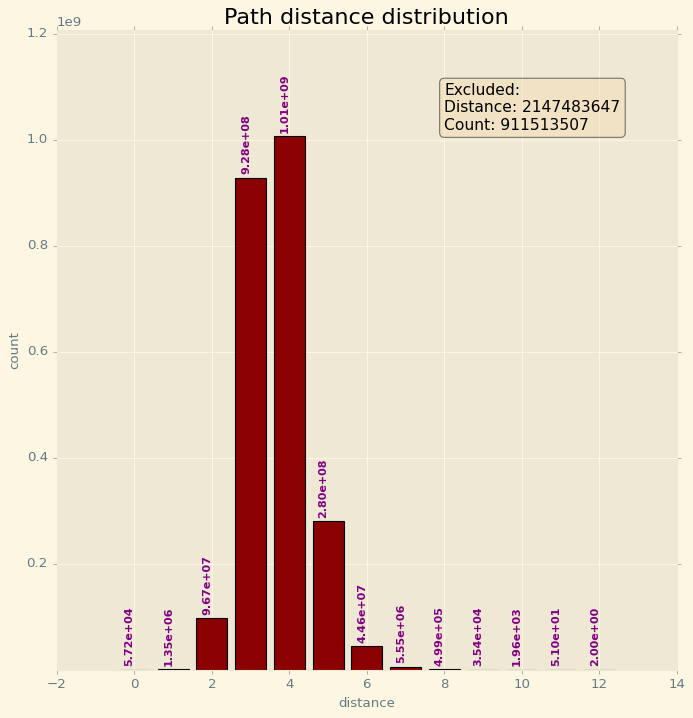

In [190]:
vals = list(hist_paths.values())[:1]
vals.extend(list(hist_paths.values())[2:])

plt.style.use('Solarize_Light2')

plt.figure(figsize=(10,10))
plt.bar(sorted(list(hist_paths.keys()))[:-1],vals,color = 'darkred')

plt.title('Path distance distribution',size=20)
plt.xlabel('distance')
plt.ylabel('count')
plt.ylim(min(vals),max(vals) * 1.2)
for i,v in enumerate(vals):
    if v > 1e4:
        n = str(np.around(v/1e9,4))
    else:
        n = str(v)
    plt.text(i-0.25,v+max(vals)/100, "{:.2e}".format(v),color = 'purple',fontweight='bold',size = 10,rotation=90)

textstr = '\n'.join((
    'Excluded:',
    f'Distance: {max(hist_paths.keys())}',
    f'Count: {hist_paths[max(hist_paths.keys())]}'
))

props = dict(boxstyle = 'round',facecolor='wheat', alpha =0.5)

plt.text(8, max(vals)*1.1, textstr,  fontsize=14,
        verticalalignment='top', bbox=props)
        
# plt.text(8,max(vals),f'Excluded distance: {max(hist_paths.keys())} \n having a count:    {hist_paths[max(hist_paths.keys())]}',size = 10,color = 'green',fontweight='bold')

plt.savefig('../images/path_distance_distribution_no_max.pdf')

the plot above kinda corroborates the negative assortativity coefficient I found before, as we don't have a long tail (i.e. higher distancees with lower counts), which is instead a sign of an assortative network.

# Community detection

In [192]:
'''
Nestest Stochastic block model
'''
state = gt.inference.minimize_blockmodel_dl(g)

In [194]:
state.draw(output='../images/NBS_full.pdf')

<Graph object, directed, with 57228 vertices and 1354579 edges, at 0x7f65542be610>

In [193]:
state

<BlockState object with 57228 blocks (648 nonempty), degree-corrected, for graph <Graph object, directed, with 57228 vertices and 1354579 edges, at 0x7f65542be610>, at 0x7f6523e7c8b0>

# Visualise the graph

In [52]:
# g = load_graph("price.xml.gz")
# age = g.vertex_properties["age"]

pos = sfdp_layout(g)
graph_draw(g, pos, output_size=(1000, 1000), vertex_color=[1,1,1,0], 
           vertex_size=1, edge_pen_width=1.2,
           vcmap=matplotlib.cm.gist_heat_r, output="graph_full.pdf")

In [ ]:
# g_test = price_network(3000)
# pos = sfdp_layout(g_test)
graph_draw(g_test, pos=pos,output_size=(1000, 1000), vertex_color=[1,1,1,111], 
           vertex_size=1, edge_pen_width=1.2,output='graph_test.pdf')